In [2]:
import pandas as pd
import xgboost as xg
import numpy as np
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import sqlite3

In [3]:
#Street and temp are the tables

sqliteConnection = sqlite3.connect('data/crime_data')        
read_in = pd.read_sql_query("""SELECT *
                            FROM street""", sqliteConnection)  
#data = pd.read_csv('metropolitanstreet.csv')
#data = read_in
#data.head()

In [4]:
read_in.to_csv('datafull.csv')

KeyboardInterrupt: 

In [5]:
data = read_in[read_in['Month'] >= '2020-01']

In [6]:
save = data

# Data  formatting

In [7]:
data = data.sort_values(by=['LSOA name', 'Month'])
monthle = LabelEncoder()
monthle.fit(data['Month'])
data['Month'] = monthle.transform(data['Month'])

LSOAle = LabelEncoder()
LSOAle.fit(data['LSOA name'])
data['LSOAencoded'] = LSOAle.transform(data['LSOA name'])

#data = data.drop(['Crime ID', 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA name', 'Last outcome category', 'Context'], axis=1)
#data = data.groupby(['Month', 'LSOAencoded']).count()
data

,Index,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOAencoded
344035,1909,None,0,Metropolitan Police Service,Metropolitan Police Service,-0.204816,51.655052,On or near Stapylton Road,E01000248,Barnet 001A,Anti-social behaviour,None,None,0
344036,1910,None,0,Metropolitan Police Service,Metropolitan Police Service,-0.203995,51.656820,On or near Parking Area,E01000248,Barnet 001A,Anti-social behaviour,None,None,0
344037,1911,bba8d1a3c6db03da856968e68f34a4efc6743e1ef23551...,0,Metropolitan Police Service,Metropolitan Police Service,-0.206936,51.654105,On or near Thornton Road,E01000248,Barnet 001A,Burglary,Status update unavailable,None,0
344038,1912,c7b90340c9a6f3efdc296eb4b36f7bc8bca31d34726cd1...,0,Metropolitan Police Service,Metropolitan Police Service,-0.206355,51.656740,On or near Alston Road,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,None,0
344039,1913,edf594d010d2844afe4643fd60a9795b6dcc242c8ef2f8...,0,Metropolitan Police Service,Metropolitan Police Service,-0.210845,51.653580,On or near Blenheim Road,E01000248,Barnet 001A,Criminal damage and arson,Status update unavailable,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114463,5019,90cadd02273825d3380deb0025f55315a8e626f701a5bb...,38,Metropolitan Police Service,Metropolitan Police Service,-0.208901,51.559805,On or near Woodley Crescent,E01000143,Barnet 041D,Shoplifting,Under investigation,None,210
114464,5020,bf49f8f6432a43bd17cb31a0b7d5be5037fbeaeebd3030...,38,Metropolitan Police Service,Metropolitan Police Service,-0.208948,51.558997,On or near Besant Road,E01000143,Barnet 041D,Violence and sexual offences,Investigation complete; no suspect identified,None,210
114465,5021,833865fbe9f98701190a32a6f9451c679af0c84488add4...,38,Metropolitan Police Service,Metropolitan Police Service,-0.207513,51.556601,On or near Horton Avenue,E01000143,Barnet 041D,Violence and sexual offences,Under investigation,None,210
114466,5022,31698cd303fa318becb1dfbb74aed3ecefdfb49e34346e...,38,Metropolitan Police Service,Metropolitan Police Service,-0.208901,51.559805,On or near Woodley Crescent,E01000143,Barnet 041D,Violence and sexual offences,Under investigation,None,210


In [8]:
preprocess = data[['Month', 'LSOAencoded', 'Crime type', 'Index']]
preprocess.sort_values(by=['LSOAencoded', 'Month'])
preprocess = preprocess.groupby(['LSOAencoded', 'Month', 'Crime type']).count()
#preprocess = preprocess.reset_index()
preprocess

Index
LSOAencoded Month Crime type                         
0           0     Anti-social behaviour            72
                  Burglary                         72
                  Criminal damage and arson        36
                  Other theft                     108
                  Robbery                         108
...                                               ...
210         38    Other theft                       4
                  Public order                      1
                  Robbery                           1
                  Shoplifting                       3
                  Violence and sexual offences      4

[45430 rows x 1 columns]

In [9]:
#This is to group by first LSOAcode and then month to achieve counts of different crimes
processed = preprocess.unstack(level=2)
processed = processed.fillna(0)
processed = processed['Index']
processed

Crime type         Anti-social behaviour  Bicycle theft  Burglary  \
LSOAencoded Month                                                   
0           0                       72.0            0.0      72.0   
            1                       72.0            0.0      36.0   
            2                      108.0            0.0      72.0   
            3                      252.0            0.0       0.0   
            4                      350.0            0.0      70.0   
...                                  ...            ...       ...   
210         34                       5.0            0.0      15.0   
            35                       8.0            4.0      12.0   
            36                       9.0            0.0       6.0   
            37                       6.0            0.0       8.0   
            38                       2.0            0.0       0.0   

Crime type         Criminal damage and arson  Drugs  Other crime  Other theft  \
LSOAencoded Month                                                               
0           0                           36.0    0.0          0.0        108.0   
            1                           36.0    0.0          0.0         72.0   
            2                           72.0    0.0          0.0         36.0   
            3                           72.0    0.0          0.0         72.0   
            4                           35.0    0.0          0.0          0.0   
...                                      ...    ...          ...          ...   
210         34                           0.0    0.0          0.0         10.0   
            35                           8.0    0.0          0.0         12.0   
            36                           0.0    0.0          0.0          6.0   
            37                           0.0    0.0          0.0         10.0   
            38                           0.0    0.0          0.0          4.0   

Crime type         Possession of weapons  Public order  Robbery  Shoplifting  \
LSOAencoded Month                                                              
0           0                        0.0           0.0    108.0        144.0   
            1                        0.0          36.0     36.0        144.0   
            2                        0.0          36.0    108.0         36.0   
            3                        0.0           0.0      0.0         36.0   
            4                        0.0           0.0      0.0          0.0   
...                                  ...           ...      ...          ...   
210         34                       5.0          10.0     20.0          5.0   
            35                       0.0           0.0      0.0          8.0   
            36                       0.0           3.0      0.0         24.0   
            37                       0.0           2.0      0.0         10.0   
            38                       0.0           1.0      1.0          3.0   

Crime type         Theft from the person  Vehicle crime  \
LSOAencoded Month                                         
0           0                       36.0          108.0   
            1                       72.0          108.0   
            2                       36.0           36.0   
            3                       72.0            0.0   
            4                        0.0           70.0   
...                                  ...            ...   
210         34                       0.0            5.0   
            35                       0.0            4.0   
            36                       0.0            3.0   
            37                       0.0            4.0   
            38                       0.0            0.0   

Crime type         Violence and sexual offences  
LSOAencoded Month                                
0           0                             144.0  
            1                               0.0  
            2                          

In [10]:
processed[39:76]

Crime type         Anti-social behaviour  Bicycle theft  Burglary  \
LSOAencoded Month                                                   
1           0                       72.0            0.0      36.0   
            1                        0.0            0.0     108.0   
            2                      108.0            0.0      36.0   
            3                      216.0            0.0      36.0   
            4                      490.0            0.0      35.0   
            5                      204.0            0.0       0.0   
            6                       33.0           33.0       0.0   
            7                       96.0            0.0      64.0   
            8                      124.0            0.0       0.0   
            9                       30.0            0.0       0.0   
            10                     174.0            0.0     116.0   
            11                      56.0            0.0      28.0   
            12                      81.0            0.0       0.0   
            13                       0.0            0.0       0.0   
            14                      75.0            0.0      50.0   
            15                      48.0            0.0       0.0   
            16                       0.0            0.0       0.0   
            17                      66.0            0.0       0.0   
            18                      63.0            0.0      21.0   
            19                      20.0            0.0       0.0   
            20                      76.0            0.0       0.0   
            21                       0.0            0.0       0.0   
            22                      17.0            0.0       0.0   
            23                      32.0            0.0       0.0   
            24                       0.0            0.0       0.0   
            25                       0.0            0.0       0.0   
            26                       0.0            0.0       0.0   
            27                      12.0            0.0       0.0   
            28                      11.0            0.0       0.0   
            29                       0.0            0.0      10.0   
            30                       9.0            0.0       9.0   
            32                       7.0            0.0       0.0   
            33                      12.0            0.0       0.0   
            34                       5.0            0.0       5.0   
            35                       0.0            0.0       0.0   
            36                       3.0            0.0       0.0   
            37                       2.0            0.0       0.0   

Crime type         Criminal damage and arson  Drugs  Other crime  Other theft  \
LSOAencoded Month                                                               
1           0                            0.0    0.0          0.0         72.0   
            1                            0.0    0.0          0.0         36.0   
            2                           36.0    0.0          0.0          0.0   
            3                            0.0    0.0          0.0          0.0   
            4                           35.0   35.0          0.0          0.0   
            5                            0.0    0.0          0.0          0.0   
            6                            0.0   66.0          0.0          0.0   
            7                            0.0    0.0          0.0         32.0   
            8                            0.0    0.0          0.0          0.0   
            9                           30.0    0.0          0.0          0.0   
            10                           0.0    0.0          0.0          0.0   
            11                           0.0    0.0          0.0          0.0   
            12                           0.0    0.0          0.0          0.0   
            13                           0.0    0.0          0.0         26.0   
            

In [11]:
#Here the target column is created and the Burglary values are shifted by 1 index, such that for each month, gets
#the previous month's burglary amount. Then the first months are dropped, since we have garbage in those fields.
processed['target'] = -1
prevburglary = -1
for index in processed.index:
    if(prevburglary == -1):
        prevburglary = processed['Burglary'][index[0]][index[1]]
    else:
        processed['target'][index[0]][index[1]] = prevburglary
        prevburglary = processed['Burglary'][index[0]][index[1]]

for index in processed.index:
    if(index[1] == 0):
        processed = processed.drop([index])
processed

Crime type         Anti-social behaviour  Bicycle theft  Burglary  \
LSOAencoded Month                                                   
0           1                       72.0            0.0      36.0   
            2                      108.0            0.0      72.0   
            3                      252.0            0.0       0.0   
            4                      350.0            0.0      70.0   
            5                      102.0            0.0       0.0   
...                                  ...            ...       ...   
210         34                       5.0            0.0      15.0   
            35                       8.0            4.0      12.0   
            36                       9.0            0.0       6.0   
            37                       6.0            0.0       8.0   
            38                       2.0            0.0       0.0   

Crime type         Criminal damage and arson  Drugs  Other crime  Other theft  \
LSOAencoded Month                                                               
0           1                           36.0    0.0          0.0         72.0   
            2                           72.0    0.0          0.0         36.0   
            3                           72.0    0.0          0.0         72.0   
            4                           35.0    0.0          0.0          0.0   
            5                          102.0   68.0          0.0         68.0   
...                                      ...    ...          ...          ...   
210         34                           0.0    0.0          0.0         10.0   
            35                           8.0    0.0          0.0         12.0   
            36                           0.0    0.0          0.0          6.0   
            37                           0.0    0.0          0.0         10.0   
            38                           0.0    0.0          0.0          4.0   

Crime type         Possession of weapons  Public order  Robbery  Shoplifting  \
LSOAencoded Month                                                              
0           1                        0.0          36.0     36.0        144.0   
            2                        0.0          36.0    108.0         36.0   
            3                        0.0           0.0      0.0         36.0   
            4                        0.0           0.0      0.0          0.0   
            5                        0.0           0.0      0.0         34.0   
...                                  ...           ...      ...          ...   
210         34                       5.0          10.0     20.0          5.0   
            35                       0.0           0.0      0.0          8.0   
            36                       0.0           3.0      0.0         24.0   
            37                       0.0           2.0      0.0         10.0   
            38                       0.0           1.0      1.0          3.0   

Crime type         Theft from the person  Vehicle crime  \
LSOAencoded Month                                         
0           1                       72.0          108.0   
            2                       36.0           36.0   
            3                       72.0            0.0   
            4                        0.0           70.0   
            5                       34.0           34.0   
...                                  ...            ...   
210         34                       0.0            5.0   
            35                       0.0            4.0   
            36                       0.0            3.0   
            37                       0.0            4.0   
            38                       0.0            0.0   

Crime type         Violence and sexual offences  target  
LSOAencoded Month                                        
0           1                               0.0      72  
            2                              36.0      36  
       

In [12]:
#Here we reset the index, such that the LSOAcodes and months no longer are indexes, so that we can use them as features.
processed = processed.reset_index().sort_values(by=['Month', 'LSOAencoded'])
processed

Crime type,LSOAencoded,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target
0,0,1,72.0,0.0,36.0,36.0,0.0,0.0,72.0,0.0,36.0,36.0,144.0,72.0,108.0,0.0,72
38,1,1,0.0,0.0,108.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,36
75,2,1,144.0,0.0,36.0,0.0,0.0,0.0,252.0,36.0,36.0,72.0,72.0,72.0,144.0,252.0,108
113,3,1,180.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,72.0,36
151,4,1,216.0,36.0,72.0,72.0,0.0,0.0,36.0,0.0,36.0,36.0,36.0,0.0,144.0,72.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7850,206,38,9.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,6
7888,207,38,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,6
7926,208,38,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4
7964,209,38,3.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,8.0,2


<Axes: >

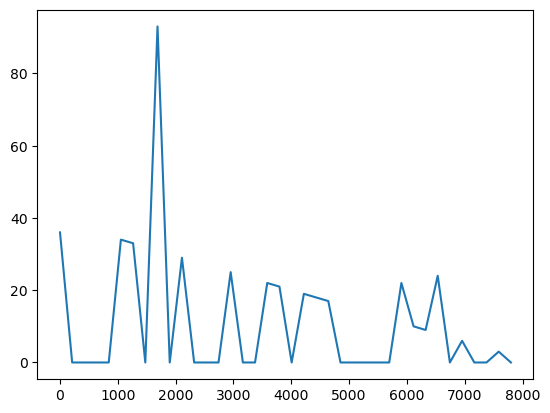

In [13]:
#By changing the lsoacode variable, you can see different lsoacode's burglary rate.
Lsoacode = 3
processed = processed.reset_index()
processed[processed['LSOAencoded'] == Lsoacode]['target'].plot()

<Axes: >

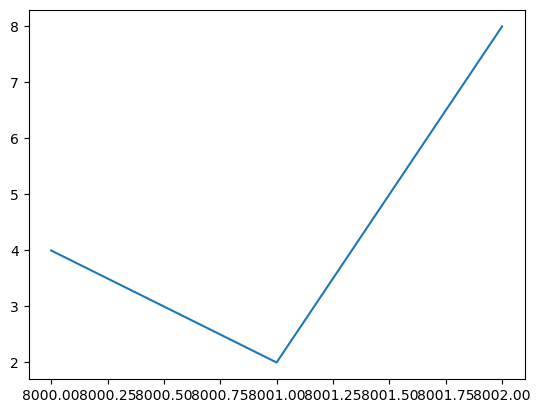

In [14]:
processed[8000:]['target'].plot()

In [15]:
y_true = processed[processed['Month'] > 30]['target']
len(y_true)

1684

In [16]:
#Here we are scaling the features, to accomodate XGBoost's requirements for features. We are creating vectors for machine learning.
features = ['LSOAencoded', 'Month', 'Anti-social behaviour', 'Bicycle theft', 'Burglary', 'Criminal damage and arson', 
            'Drugs', 'Other crime', 'Other theft', 'Possession of weapons', 'Public order', 'Robbery', 'Shoplifting',
           'Theft from the person', 'Vehicle crime', 'Violence and sexual offences']
scaler = MinMaxScaler()
array = processed[features]
array[features] = scaler.fit_transform(processed[features])
array

/var/folders/y7/xn_n0zrd2fsfmr0jhsjgsksh0000gn/T/ipykernel_2136/3307025400.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  array[features] = scaler.fit_transform(processed[features])


Crime type,LSOAencoded,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
0,0.000000,0.0,0.039216,0.000000,0.142857,0.075000,0.00000,0.0,0.037618,0.000000,0.083916,0.083333,0.108108,0.075,0.198529,0.000000
1,0.004762,0.0,0.000000,0.000000,0.428571,0.000000,0.00000,0.0,0.018809,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.122449
2,0.009524,0.0,0.078431,0.000000,0.142857,0.000000,0.00000,0.0,0.131661,0.333333,0.083916,0.166667,0.054054,0.075,0.264706,0.428571
3,0.014286,0.0,0.098039,0.363636,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.132353,0.122449
4,0.019048,0.0,0.117647,0.363636,0.285714,0.150000,0.00000,0.0,0.018809,0.000000,0.083916,0.083333,0.027027,0.000,0.264706,0.122449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7998,0.980952,1.0,0.004902,0.000000,0.011905,0.002083,0.00000,0.0,0.000522,0.000000,0.000000,0.000000,0.000000,0.000,0.001838,0.005102
7999,0.985714,1.0,0.001089,0.000000,0.000000,0.000000,0.00463,0.0,0.000522,0.000000,0.000000,0.002315,0.000000,0.000,0.003676,0.005102
8000,0.990476,1.0,0.000000,0.000000,0.011905,0.000000,0.00000,0.0,0.000522,0.000000,0.000000,0.000000,0.000000,0.000,0.005515,0.006803
8001,0.995238,1.0,0.001634,0.000000,0.011905,0.000000,0.00000,0.0,0.000522,0.000000,0.002331,0.002315,0.000000,0.000,0.005515,0.013605


In [17]:
len(array), len(y_true)

(8003, 1684)

In [18]:
y_true.reset_index()
y_true

6319    9
6320    0
6321    9
6322    9
6323    0
       ..
7998    6
7999    6
8000    4
8001    2
8002    8
Name: target, Length: 1684, dtype: int64

In [19]:
#Assigning the training and testing datasets, with a circa 80-20 split
X_train = array[:6319]
y_train = processed[processed['Month'] <= 30]['target']
X_test = array[6319:]
y_test = processed[processed['Month'] > 30]['target']
len(X_train), len(X_test), len(y_train), len(y_test)

(6319, 1684, 6319, 1684)

# Model setup

In [20]:
# create model
model = xg.XGBRFRegressor(n_estimators=200, max_depth=12, learning_rate=1)#objective='binary:logistic')
# fit model
model.fit(X_train, y_train)
# make predictions
preds = model.predict(X_test)
preds

array([ 9.17997 , 12.045101,  6.910946, ..., 20.909119, 21.00624 ,
       21.720364], dtype=float32)

In [21]:
#preds = scaler.inverse_transform(preds.reshape(-1, 1))
#preds.reshape()
#preds.max()
X_test.shape, y_true.shape, preds.shape

((1684, 16), (1684,), (1684,))

In [22]:
#Here we get the mean absolute error of the predictions compared to the truth values on the test set.
mae = mean_absolute_error(y_true, preds)
mae

6.372762636164305

<Axes: >

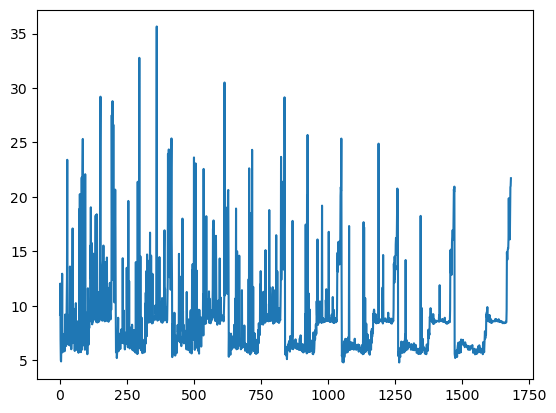

In [23]:
#Here is a plot of the predictions
pd.Series(preds.ravel()).plot()

<Axes: >

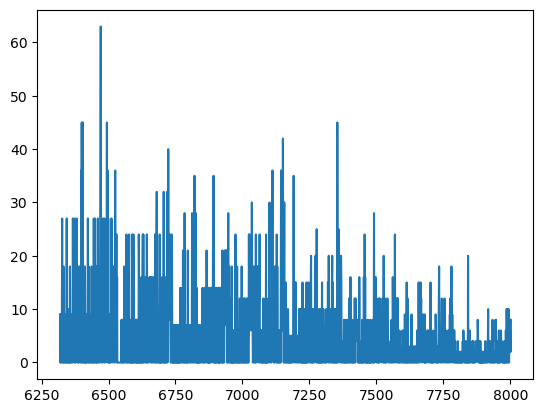

In [24]:
#Here is a plot of the true values
y_true.plot()